In [ ]:
!pip install import-ipynb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 80.9 MB/s eta 0:00:00


In [ ]:
!pip install utils

  Preparing metadata (setup.py) ... done
  Created wheel for utils: filename=utils-1.0.2-py2.py3-none-any.whl size=13906 sha256=b8782576e08250afb076ec840b3131a7d78a02131fc4d8e591cbd2a57812180f
  Stored in directory: /root/.cache/pip/wheels/b6/a1/81/1036477786ae0e17b522f6f5a838f9bc4288d1016fc5d0e1ec
Successfully built utils


In [ ]:
pip install numpy gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.6/26.6 MB 90.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 119.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.2/38.2 MB 62.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.1
    Uninstalling scipy-1.16.1:
      Successfully uninstalled scipy-1.16.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
thin

In [ ]:
import import_ipynb
import text_utils
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import ADASYN
import pickle
import os
import requests
import zipfile
from tqdm import tqdm
from huggingface_hub import HfApi, Repository, hf_hub_download
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score, normalized_mutual_info_score, homogeneity_score, completeness_score, v_measure_score
from sklearn.metrics import accuracy_score, f1_score
from imblearn.over_sampling import SMOTE
from gensim.models import KeyedVectors
import gensim.downloader as api

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
from huggingface_hub import Repository, login
import os
import pickle
import torch

def push_to_hub(model, embeddings_index, repo_name="ali9999/fake-job-detection-model", hf_token=None):
    """
    Push the trained model and GloVe embeddings index to Hugging Face Hub.
    """
    if hf_token:
        login(token=hf_token)  # Optional: for explicit login

    model_path = "fraud_model.pt"
    embeddings_path = "embeddings_index.pkl"
    repo_dir = "hf_model_repo"

    # Save locally
    torch.save(model.state_dict(), model_path)
    with open(embeddings_path, "wb") as f:
        pickle.dump(embeddings_index, f)

    # Clone or initialize repo
    if os.path.exists(repo_dir):
        os.system(f"rm -rf {repo_dir}")  # optional: clean before re-cloning

    repo = Repository(local_dir=repo_dir, clone_from=repo_name)

    # Move files to repo directory
    os.replace(model_path, os.path.join(repo_dir, model_path))
    os.replace(embeddings_path, os.path.join(repo_dir, embeddings_path))

    os.system('git config --global user.email "sayyidaliahmed1@gmail.com"')
    os.system('git config --global user.name "Ali Ahmed"')

    # Push
    repo.git_add()
    repo.git_commit("Add model and embeddings index")
    repo.git_push()


In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
class Embedder(nn.Module):
    def __init__(self, input_dim=300, embed_dim=16, num_classes=2):
        super(Embedder, self).__init__()
        self.embedding = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 40),
            nn.ReLU(),
            nn.Linear(40, 32),
            nn.ReLU(),
            nn.Linear(32, embed_dim),
        )
        self.classifier = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        z = self.embedding(x)
        logits = self.classifier(z)
        return z, logits


In [ ]:
def custom_loss(embeddings, logits, labels, k=5, alpha=0.7, margin=1.0, beta=0.4):
    # Balanced cross-entropy
    class_counts = torch.bincount(labels)
    weights = 1.0 / (class_counts.float() + 1e-8)
    weights = weights.to(logits.device)
    classification_loss = nn.functional.cross_entropy(logits, labels, weight=weights)

    embeddings = nn.functional.normalize(embeddings, p=2, dim=1)
    contrastive_loss = 0.0
    loss_count = 0

    for cls in torch.unique(labels):
        same_mask = labels == cls
        other_mask = labels != cls
        cluster = embeddings[same_mask]
        other = embeddings[other_mask]

        if cluster.size(0) < k + 1 or other.size(0) < k:
            continue

        # Dynamically computed centroid (differentiable)
        centroid = cluster.mean(dim=0, keepdim=True)

        # Pull loss (within class)
        dists_within = torch.norm(cluster - centroid, dim=1)
        farthest = cluster[torch.topk(dists_within, k).indices]
        pull_loss = torch.sum((farthest - centroid) ** 2)

        # Push loss (between class)
        dists_other = torch.norm(other - centroid, dim=1)
        topk_closest = other[torch.topk(-dists_other, k).indices]
        push_dists = torch.norm(topk_closest - centroid.squeeze(), dim=1)
        push_loss = torch.sum(torch.clamp(margin - push_dists, min=0) ** 2)

        # Balanced contrastive loss
        contrastive_loss += (1 - alpha) * pull_loss + alpha * push_loss
        loss_count += 1

    contrastive_loss = contrastive_loss / max(loss_count, 1)
    return beta * classification_loss + (1 - beta) * contrastive_loss


In [ ]:
def document_vector(text, word2vec_model, dim=300):
    """Compute the average Word2Vec vector for a document."""
    words = text.split()  # Simple tokenization; adjust based on your preprocessing
    vectors = [word2vec_model[word] for word in words if word in word2vec_model]
    if len(vectors) == 0:
        return np.zeros(dim)  # Return zero vector if no valid words
    return np.mean(vectors, axis=0)

In [ ]:
import matplotlib.pyplot as plt

def plot_centroids(embeddings, labels, epoch):
    emb_np = embeddings.detach().cpu().numpy()
    labels_np = labels.cpu().numpy()

    # Compute centroids for each class
    centroids = []
    for cls in torch.unique(labels):
        mask = labels == cls
        class_embs = emb_np[mask.cpu().numpy()]
        centroid = class_embs.mean(axis=0)
        centroids.append((cls.item(), centroid))

    # Plot first 2 dims + centroids
    plt.figure(figsize=(6, 6))
    plt.scatter(emb_np[:, 0], emb_np[:, 1], c=labels_np, cmap='coolwarm', alpha=0.5, s=10)
    for cls, centroid in centroids:
        plt.scatter(centroid[0], centroid[1], label=f"Centroid Class {cls}", s=120, marker='X', edgecolors='black')
    plt.title(f"Class Centroids - Epoch {epoch}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"centroid_plot_epoch_{epoch}.png")
    plt.close()

def train():
    # Load pre-cleaned dataset
    df = pd.read_csv("cleaned_dataset.csv")
    X_texts = df['text'].tolist()
    y = df['fraudulent'].values

    #Load GloVe vectors
    glove_txt_path = text_utils.download_glove(destination_folder='glove', dim=300)
    embeddings_index = text_utils.load_glove_embeddings(glove_txt_path)
        # Load or download Word2Vec model

    '''
    model_name = "word2vec-google-news-300"
    cache_path = os.path.join(os.path.expanduser("~"), "gensim-data", model_name, f"{model_name}.gz")
    print("Checking for cached Word2Vec model...")
    try:
        # Check if model is already cached
        if os.path.exists(cache_path):
            print(f"Loading cached Word2Vec model from {cache_path}...")
            word2vec_model = KeyedVectors.load_word2vec_format(cache_path, binary=True)
            print("Cached Word2Vec model loaded.")
        else:
            print(f"Downloading {model_name}...")
            word2vec_model = api.load(model_name)
            print("Word2Vec model downloaded and loaded.")
    except Exception as e:
        print(f"Error loading Word2Vec model: {e}")
        exit(1)


    '''
    X_vectors = np.array([text_utils.document_vector(text, embeddings_index) for text in X_texts])

    #X_vectors = np.array([document_vector(text, word2vec_model, dim=300) for text in X_texts])

    # Handle class imbalance
    adasyn = ADASYN(sampling_strategy=0.4, random_state=42, n_neighbors=5)
    X_res, y_res = adasyn.fit_resample(X_vectors, y)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42, stratify=y_res)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long)

    # Initialize model
    model = Embedder()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    model.train()

    # Training loop
    for epoch in range(3000):
        optimizer.zero_grad()
        embeddings, logits = model(X_train_tensor)
        loss = custom_loss(embeddings, logits, y_train_tensor)
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

        # Plot centroids every 500 epochs
        if (epoch + 1) % 500 == 0:
            print(f"Plotting centroids at epoch {epoch+1}")
            plot_centroids(embeddings, y_train_tensor, epoch + 1)

    # Save model and embeddings
    #torch.save(model.state_dict(), "fraud_model.pt")
    #with open("embeddings_index.pkl", "wb") as f:
        #pickle.dump(embeddings_index, f)

    #torch.save(model.state_dict(), "fraud_model.pt")
    #with open("word2vec_model.pkl", "wb") as f:
        #word2vec_model.save(f)


    print("Training done and saved locally.")
    #return model, X_test_tensor, y_test_tensor, embeddings_index

    return model, X_test_tensor, y_test_tensor


In [ ]:
if __name__ == "__main__":
    model, X_test_tensor, y_test_np = train()
    model.eval()
    with torch.no_grad():
        emb_test, logits_test = model(X_test_tensor)

    # Predictions
    preds = torch.argmax(logits_test, dim=1).numpy()

    #push_to_hub(model, embeddings_index, repo_name="ali9999/fake-job-detection-model")
    #print("Pushed model and embeddings to Hugging Face Hub.")


GloVe file already exists at: glove/glove.6B.300d.txt
Epoch 10, Loss: 2.3697
Epoch 20, Loss: 2.2815
Epoch 30, Loss: 2.0112
Epoch 40, Loss: 1.4005
Epoch 50, Loss: 1.1269
Epoch 60, Loss: 1.0970
Epoch 70, Loss: 1.0917
Epoch 80, Loss: 1.0351
Epoch 90, Loss: 1.0079
Epoch 100, Loss: 0.9554
Epoch 110, Loss: 0.9624
Epoch 120, Loss: 0.9464
Epoch 130, Loss: 0.9792
Epoch 140, Loss: 0.9451
Epoch 150, Loss: 0.8630
Epoch 160, Loss: 0.9717
Epoch 170, Loss: 0.8625
Epoch 180, Loss: 0.8212
Epoch 190, Loss: 0.8264
Epoch 200, Loss: 0.9915
Epoch 210, Loss: 0.8382
Epoch 220, Loss: 0.7724
Epoch 230, Loss: 0.7596
Epoch 240, Loss: 0.8140
Epoch 250, Loss: 0.7623
Epoch 260, Loss: 0.7728
Epoch 270, Loss: 0.7932
Epoch 280, Loss: 0.8289
Epoch 290, Loss: 0.7616
Epoch 300, Loss: 0.7545
Epoch 310, Loss: 0.7359
Epoch 320, Loss: 0.7614
Epoch 330, Loss: 0.7220
Epoch 340, Loss: 0.7311
Epoch 350, Loss: 0.7564
Epoch 360, Loss: 0.9222
Epoch 370, Loss: 0.8157
Epoch 380, Loss: 0.8524
Epoch 390, Loss: 0.8483
Epoch 400, Loss: 0.


Accuracy: 0.760, F1 Score: 0.683

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.70      0.81      3403
           1       0.55      0.91      0.68      1367

    accuracy                           0.76      4770
   macro avg       0.75      0.80      0.74      4770
weighted avg       0.83      0.76      0.77      4770


Silhouette Score: -0.036
Adjusted Rand Index: 0.269


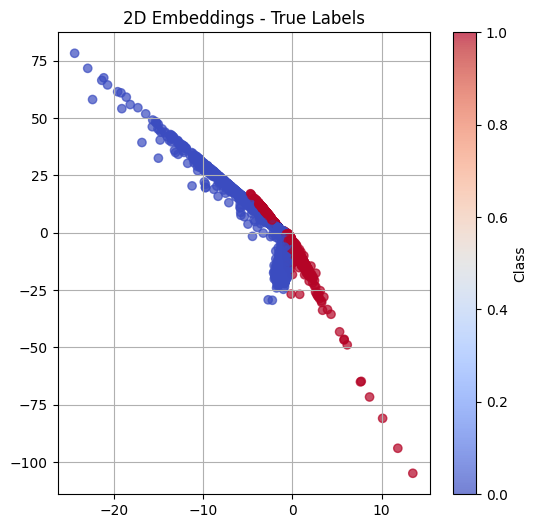


Normalized Mutual Information: 0.259
Homogeneity Score: 0.278
Completeness Score: 0.241
V-Measure: 0.259
Calinski-Harabasz Score: 26.648
Davies-Bouldin Score: 9.251


In [ ]:
acc = accuracy_score(y_test_np, preds)
f1 = f1_score(y_test_np, preds)
print(f"\nAccuracy: {acc:.3f}, F1 Score: {f1:.3f}")
print("\nClassification Report:\n", classification_report(y_test_np, preds))
# Clustering metrics
emb_np = emb_test.numpy()
sil_score = silhouette_score(emb_np, y_test_np)
ari = adjusted_rand_score(y_test_np, preds)
print(f"\nSilhouette Score: {sil_score:.3f}")
print(f"Adjusted Rand Index: {ari:.3f}")

# Visualization
plt.figure(figsize=(6, 6))
plt.scatter(emb_np[:, 0], emb_np[:, 1], c=preds, cmap='coolwarm', alpha=0.7)
plt.title("2D Embeddings - True Labels")
plt.colorbar(label="Class")
plt.grid(True)
plt.show()

# These use true labels vs predicted clusters
nmi = normalized_mutual_info_score(y_test_np, preds)
hom = homogeneity_score(y_test_np, preds)
comp = completeness_score(y_test_np, preds)
v_score = v_measure_score(y_test_np, preds)

# These use embeddings only
ch_score = calinski_harabasz_score(emb_np, y_test_np)
db_score = davies_bouldin_score(emb_np, y_test_np)

print(f"\nNormalized Mutual Information: {nmi:.3f}")
print(f"Homogeneity Score: {hom:.3f}")
print(f"Completeness Score: {comp:.3f}")
print(f"V-Measure: {v_score:.3f}")
print(f"Calinski-Harabasz Score: {ch_score:.3f}")
print(f"Davies-Bouldin Score: {db_score:.3f}")

#TESTING FOR ABLATION STUDY

In [ ]:
import os
import numpy as np
import pandas as pd
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report,
    silhouette_score, adjusted_rand_score,
    normalized_mutual_info_score, homogeneity_score,
    completeness_score, v_measure_score,
    calinski_harabasz_score, davies_bouldin_score
)
from imblearn.over_sampling import ADASYN
from gensim.models import KeyedVectors
import gensim.downloader as api


# -------------------------------
# Utilities
# -------------------------------
def document_vector(text, word2vec_model, dim=300):
    """Compute the average Word2Vec vector for a document."""
    words = text.split()
    vectors = [word2vec_model[word] for word in words if word in word2vec_model]
    if len(vectors) == 0:
        return np.zeros(dim)
    return np.mean(vectors, axis=0)


def plot_centroids(embeddings, labels, epoch):
    emb_np = embeddings.detach().cpu().numpy()
    labels_np = labels.cpu().numpy()

    centroids = []
    for cls in torch.unique(labels):
        mask = labels == cls
        class_embs = emb_np[mask.cpu().numpy()]
        centroid = class_embs.mean(axis=0)
        centroids.append((cls.item(), centroid))

    plt.figure(figsize=(6, 6))
    plt.scatter(emb_np[:, 0], emb_np[:, 1], c=labels_np, cmap='coolwarm', alpha=0.5, s=10)
    for cls, centroid in centroids:
        plt.scatter(centroid[0], centroid[1], label=f"Centroid Class {cls}", s=120,
                    marker='X', edgecolors='black')
    plt.title(f"Class Centroids - Epoch {epoch}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"centroid_plot_epoch_{epoch}.png")
    plt.close()


# -------------------------------
# Training Pipeline
# -------------------------------
def train_and_evaluate(params):
    """
    Train and evaluate the model with given hyperparameters.

    params: dict containing hyperparameters
        {
            'epochs': 1000,
            'lr': 0.01,
            'alpha': 1.0,
            'beta': 0.5,
            'k': 5
        }
    """
    # 1. Load dataset
    df = pd.read_csv("cleaned_dataset.csv")
    X_texts = df['text'].tolist()
    y = df['fraudulent'].values

    glove_txt_path = text_utils.download_glove(destination_folder='glove', dim=300)
    embeddings_index = text_utils.load_glove_embeddings(glove_txt_path)

    '''
    # 2. Load word embeddings (with fallback)
    model_name = "word2vec-google-news-300"
    try:
        word2vec_model = api.load(model_name)
    except Exception as e:
        print(f"Error loading {model_name}: {e}")
        print("Falling back to smaller model (glove-wiki-gigaword-100)...")
        word2vec_model = api.load("glove-wiki-gigaword-100")

    '''
    X_vectors = np.array([text_utils.document_vector(text, embeddings_index) for text in X_texts])
    # 3. Convert docs to vectors
    #X_vectors = np.array([document_vector(text, word2vec_model, dim=300) for text in X_texts])

    # 4. Handle imbalance
    adasyn = ADASYN(sampling_strategy=0.4, random_state=42, n_neighbors=params.get('k', 5))
    X_res, y_res = adasyn.fit_resample(X_vectors, y)

    # 5. Split dataset
    X_train, X_test, y_train, y_test = train_test_split(
        X_res, y_res, test_size=0.2, random_state=42, stratify=y_res
    )
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long)

    # 6. Initialize model
    model = Embedder()  # your model class must be defined elsewhere
    optimizer = optim.Adam(model.parameters(), lr=params.get('lr', 0.01))
    model.train()

    # 7. Training loop
    for epoch in range(params.get('epochs', 1000)):
        optimizer.zero_grad()
        embeddings, logits = model(X_train_tensor)
        loss = custom_loss(
            embeddings, logits, y_train_tensor,
            alpha=params.get('alpha', 1.0),
            beta=params.get('beta', 0.5)
        )
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")
        if (epoch + 1) % 500 == 0:
            plot_centroids(embeddings, y_train_tensor, epoch + 1)

    # 8. Evaluation
    model.eval()
    with torch.no_grad():
        emb_test, logits_test = model(X_test_tensor)
    preds = torch.argmax(logits_test, dim=1).numpy()
    y_true = y_test_tensor.numpy()

    # --- Metrics ---
    acc = accuracy_score(y_true, preds)
    f1 = f1_score(y_true, preds)

    print("\nClassification Report:\n")
    print(classification_report(y_true, preds, digits=3))

    sil_score = silhouette_score(emb_test.numpy(), y_true)
    ari = adjusted_rand_score(y_true, preds)
    nmi = normalized_mutual_info_score(y_true, preds)
    hom = homogeneity_score(y_true, preds)
    comp = completeness_score(y_true, preds)
    v_score = v_measure_score(y_true, preds)
    ch_score = calinski_harabasz_score(emb_test.numpy(), y_true)
    db_score = davies_bouldin_score(emb_test.numpy(), y_true)

    results = {
        "Accuracy": acc,
        "F1": f1,
        "Silhouette": sil_score,
        "ARI": ari,
        "NMI": nmi,
        "Homogeneity": hom,
        "Completeness": comp,
        "V-Measure": v_score,
        "CH-Score": ch_score,
        "DB-Score": db_score
    }
    return results


# -------------------------------
# Example: Hyperparameter Tuning
# -------------------------------
import itertools

if __name__ == "__main__":
    # Define ranges for hyperparameters
    alpha_values = [0.5, 1.0, 1.5]
    beta_values = [0.3, 0.5, 0.7]
    k_values = [5, 7, 10]

    # Create all possible combinations
    param_grid = [
        {"epochs": 3000, "lr": 0.01, "alpha": a, "beta": b, "k": k}
        for a, b, k in itertools.product(alpha_values, beta_values, k_values)
    ]

    print(f"Total experiments: {len(param_grid)}")

    # Run all experiments
    for i, params in enumerate(param_grid):
        print(f"\n=== Experiment {i+1}/{len(param_grid)} with params: {params} ===")
        results = train_and_evaluate(params)
        print("Results:", results)



Total experiments: 27

=== Experiment 1/27 with params: {'epochs': 3000, 'lr': 0.01, 'alpha': 0.5, 'beta': 0.3, 'k': 5} ===
GloVe file already exists at: glove/glove.6B.300d.txt
Epoch 10, Loss: 1.2571
Epoch 20, Loss: 1.2504
Epoch 30, Loss: 1.2131
Epoch 40, Loss: 1.1714
Epoch 50, Loss: 1.0644
Epoch 60, Loss: 0.9501
Epoch 70, Loss: 0.9000
Epoch 80, Loss: 0.8380
Epoch 90, Loss: 0.8845
Epoch 100, Loss: 0.8191
Epoch 110, Loss: 0.7650
Epoch 120, Loss: 0.7535
Epoch 130, Loss: 0.7333
Epoch 140, Loss: 0.6971
Epoch 150, Loss: 0.6814
Epoch 160, Loss: 0.6813
Epoch 170, Loss: 0.7469
Epoch 180, Loss: 0.7039
Epoch 190, Loss: 0.6540
Epoch 200, Loss: 0.6450
Epoch 210, Loss: 0.6389
Epoch 220, Loss: 0.6493
Epoch 230, Loss: 0.6082
Epoch 240, Loss: 0.6376
Epoch 250, Loss: 0.6051
Epoch 260, Loss: 0.6175
Epoch 270, Loss: 0.6033
Epoch 280, Loss: 0.6035
Epoch 290, Loss: 0.5821
Epoch 300, Loss: 0.6443
Epoch 310, Loss: 0.6475
Epoch 320, Loss: 0.6259
Epoch 330, Loss: 0.5843
Epoch 340, Loss: 0.6408
Epoch 350, Loss

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Results: {'Accuracy': 0.2858342077649528, 'F1': 0.4445895217888037, 'Silhouette': 0.0, 'ARI': 0.0, 'NMI': 0.0, 'Homogeneity': 0.0, 'Completeness': 1.0, 'V-Measure': 0.0, 'CH-Score': 10523.165705507261, 'DB-Score': 2.053427038676589}

=== Experiment 15/27 with params: {'epochs': 3000, 'lr': 0.01, 'alpha': 1.0, 'beta': 0.5, 'k': 10} ===
GloVe file already exists at: glove/glove.6B.300d.txt
Epoch 10, Loss: 1.8281
Epoch 20, Loss: 0.6452
Epoch 30, Loss: 0.3592
Epoch 40, Loss: 0.3440
Epoch 50, Loss: 0.3348
Epoch 60, Loss: 0.3123
Epoch 70, Loss: 0.2748
Epoch 80, Loss: 0.2462
Epoch 90, Loss: 0.2178
Epoch 100, Loss: 0.2252
Epoch 110, Loss: 0.1902
Epoch 120, Loss: 0.1644
Epoch 130, Loss: 0.1417
Epoch 140, Loss: 0.1739
Epoch 150, Loss: 0.1449
Epoch 160, Loss: 0.1142
Epoch 170, Loss: 0.0932
Epoch 180, Loss: 0.1141
Epoch 190, Loss: 0.0854
Epoch 200, Loss: 0.0722
Epoch 210, Loss: 0.3342
Epoch 220, Loss: 0.1598
Epoch 230, Loss: 0.1111
Epoch 240, Loss: 0.0826
Epoch 250, Loss: 0.0695
Epoch 260, Loss: 0

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Results: {'Accuracy': 0.7134171907756813, 'F1': 0.0, 'Silhouette': 0.0, 'ARI': 0.0, 'NMI': 0.0, 'Homogeneity': 0.0, 'Completeness': 1.0, 'V-Measure': 0.0, 'CH-Score': 10497.937614930914, 'DB-Score': 1.0632663840610888}

=== Experiment 20/27 with params: {'epochs': 3000, 'lr': 0.01, 'alpha': 1.5, 'beta': 0.3, 'k': 7} ===
GloVe file already exists at: glove/glove.6B.300d.txt
Epoch 10, Loss: 3.3551
Epoch 20, Loss: 3.3584
Epoch 30, Loss: 3.3777
Epoch 40, Loss: 1.9663
Epoch 50, Loss: 0.8995
Epoch 60, Loss: -1.2883
Epoch 70, Loss: -1.3295
Epoch 80, Loss: -1.3608
Epoch 90, Loss: -1.3973
Epoch 100, Loss: -1.5834
Epoch 110, Loss: -2.1227
Epoch 120, Loss: -2.4134
Epoch 130, Loss: -2.5489
Epoch 140, Loss: -2.5554
Epoch 150, Loss: -2.6006
Epoch 160, Loss: -2.4135
Epoch 170, Loss: -2.5196
Epoch 180, Loss: -2.6127
Epoch 190, Loss: -2.6596
Epoch 200, Loss: -2.6569
Epoch 210, Loss: -2.6279
Epoch 220, Loss: -2.6286
Epoch 230, Loss: -2.6144
Epoch 240, Loss: -2.6550
Epoch 250, Loss: -2.6544
Epoch 260, Lo

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Results: {'Accuracy': 0.2858342077649528, 'F1': 0.4445895217888037, 'Silhouette': 0.0, 'ARI': 0.0, 'NMI': 0.0, 'Homogeneity': 0.0, 'Completeness': 1.0, 'V-Measure': 0.0, 'CH-Score': 8890.093245022546, 'DB-Score': 1.2888455036040103}

=== Experiment 24/27 with params: {'epochs': 3000, 'lr': 0.01, 'alpha': 1.5, 'beta': 0.5, 'k': 10} ===
GloVe file already exists at: glove/glove.6B.300d.txt
Epoch 10, Loss: -0.5105
Epoch 20, Loss: -0.7247
Epoch 30, Loss: -0.7643
Epoch 40, Loss: -0.8064
Epoch 50, Loss: -1.4524
Epoch 60, Loss: -1.3618
Epoch 70, Loss: -1.4932
Epoch 80, Loss: -1.4908
Epoch 90, Loss: -1.5268
Epoch 100, Loss: -1.6170
Epoch 110, Loss: -1.6730
Epoch 120, Loss: -1.6995
Epoch 130, Loss: -1.6829
Epoch 140, Loss: -1.6875
Epoch 150, Loss: -1.6916
Epoch 160, Loss: -1.6575
Epoch 170, Loss: -1.6694
Epoch 180, Loss: -1.6811
Epoch 190, Loss: -1.6988
Epoch 200, Loss: -1.6255
Epoch 210, Loss: -1.6054
Epoch 220, Loss: -1.6019
Epoch 230, Loss: -1.6058
Epoch 240, Loss: -1.6531
Epoch 250, Loss: -

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Results: {'Accuracy': 0.7131181894383906, 'F1': 0.0, 'Silhouette': 0.0, 'ARI': 0.0, 'NMI': 0.0, 'Homogeneity': 0.0, 'Completeness': 1.0, 'V-Measure': 0.0, 'CH-Score': 11746.383754784441, 'DB-Score': 1.6531942922176717}

=== Experiment 25/27 with params: {'epochs': 3000, 'lr': 0.01, 'alpha': 1.5, 'beta': 0.7, 'k': 5} ===
GloVe file already exists at: glove/glove.6B.300d.txt
Epoch 10, Loss: -0.1296
Epoch 20, Loss: -0.1388
Epoch 30, Loss: -0.1691
Epoch 40, Loss: -0.1812
Epoch 50, Loss: -0.1879
Epoch 60, Loss: -0.1954
Epoch 70, Loss: -0.3014
Epoch 80, Loss: -0.5169
Epoch 90, Loss: -0.6679
Epoch 100, Loss: -0.6857
Epoch 110, Loss: -0.7337
Epoch 120, Loss: -0.7236
Epoch 130, Loss: -0.7360
Epoch 140, Loss: -0.7051
Epoch 150, Loss: -0.7140
Epoch 160, Loss: -0.7473
Epoch 170, Loss: -0.7272
Epoch 180, Loss: -0.7412
Epoch 190, Loss: -0.7249
Epoch 200, Loss: -0.7505
Epoch 210, Loss: -0.7542
Epoch 220, Loss: -0.7296
Epoch 230, Loss: -0.7049
Epoch 240, Loss: -0.7473
Epoch 250, Loss: -0.7564
Epoch 26

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Results: {'Accuracy': 0.7134171907756813, 'F1': 0.0, 'Silhouette': 0.0035982055, 'ARI': 0.0, 'NMI': 0.0, 'Homogeneity': 0.0, 'Completeness': 1.0, 'V-Measure': 0.0, 'CH-Score': 11959.022945328335, 'DB-Score': 1.5500218428846613}

=== Experiment 26/27 with params: {'epochs': 3000, 'lr': 0.01, 'alpha': 1.5, 'beta': 0.7, 'k': 7} ===
GloVe file already exists at: glove/glove.6B.300d.txt
Epoch 10, Loss: -0.1521
Epoch 20, Loss: -0.1716
Epoch 30, Loss: -0.1998
Epoch 40, Loss: -0.3439
Epoch 50, Loss: -0.6446
Epoch 60, Loss: -0.7153
Epoch 70, Loss: -0.6795
Epoch 80, Loss: -0.6824
Epoch 90, Loss: -0.7257
Epoch 100, Loss: -0.6417
Epoch 110, Loss: -0.7457
Epoch 120, Loss: -0.6230
Epoch 130, Loss: -0.7132
Epoch 140, Loss: -0.7502
Epoch 150, Loss: -0.7592
Epoch 160, Loss: -0.7615
Epoch 170, Loss: -0.7510
Epoch 180, Loss: -0.7597
Epoch 190, Loss: -0.7755
Epoch 200, Loss: -0.7101
Epoch 210, Loss: -0.7638
Epoch 220, Loss: -0.7807
Epoch 230, Loss: -0.8081
Epoch 240, Loss: -0.8462
Epoch 250, Loss: -0.7355

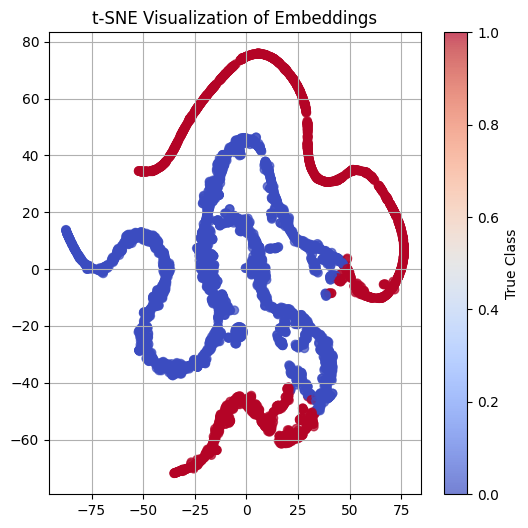

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
emb_tsne = tsne.fit_transform(emb_np)

plt.figure(figsize=(6, 6))
plt.scatter(emb_tsne[:, 0], emb_tsne[:, 1], c=preds, cmap='coolwarm', alpha=0.7)
plt.title("t-SNE Visualization of Embeddings")
plt.colorbar(label="True Class")
plt.grid(True)
plt.show()


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



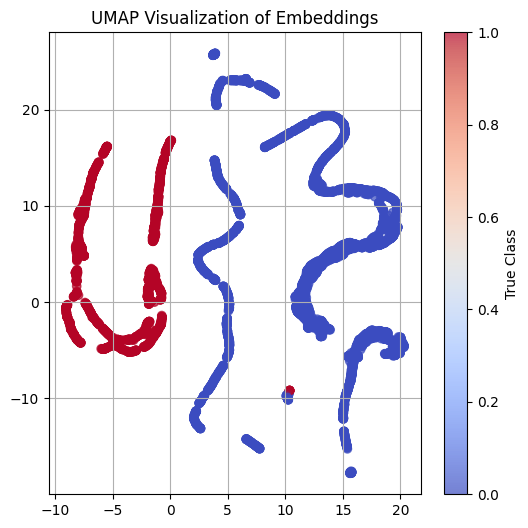

In [ ]:
import umap.umap_ as umap

reducer = umap.UMAP(random_state=42)
emb_umap = reducer.fit_transform(emb_np)

plt.figure(figsize=(6, 6))
plt.scatter(emb_umap[:, 0], emb_umap[:, 1], c=preds, cmap='coolwarm', alpha=0.7)
plt.title("UMAP Visualization of Embeddings")
plt.colorbar(label="True Class")
plt.grid(True)
plt.show()


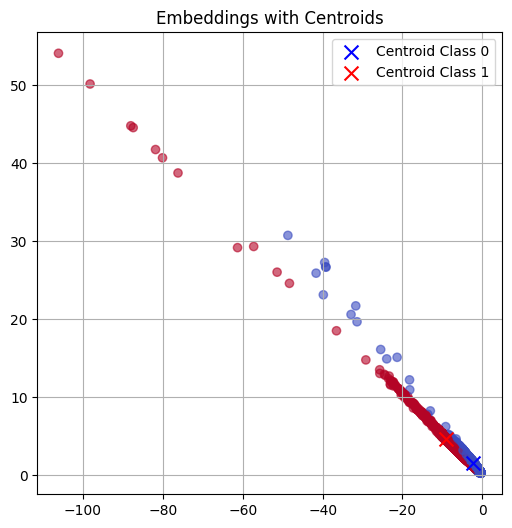

In [ ]:
import numpy as np

class0_mask = preds == 0
class1_mask = preds == 1

centroid_0 = emb_np[class0_mask].mean(axis=0)
centroid_1 = emb_np[class1_mask].mean(axis=0)

plt.figure(figsize=(6, 6))
plt.scatter(emb_np[:, 0], emb_np[:, 1], c=preds, cmap='coolwarm', alpha=0.6)
plt.scatter(*centroid_0[:2], c='blue', s=100, marker='x', label='Centroid Class 0')
plt.scatter(*centroid_1[:2], c='red', s=100, marker='x', label='Centroid Class 1')
plt.title("Embeddings with Centroids")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import plotly.express as px
fig = px.scatter(x=emb_tsne[:, 0], y=emb_tsne[:, 1], color=preds.astype(str), title="Interactive t-SNE")
fig.show()

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_iris, load_wine, load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import os

# ========== Embedder Model ==========
class Embedder(nn.Module):
    def __init__(self, input_dim=20, embed_dim=16, num_classes=3):
        super(Embedder, self).__init__()
        self.embedding = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, embed_dim),
        )
        self.classifier = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        z = self.embedding(x)
        logits = self.classifier(z)
        return z, logits

# ========== Custom Loss ==========
def custom_loss(embeddings, logits, labels, k=3, alpha=1.0, margin=1.0, beta=0.7):
    class_counts = torch.bincount(labels)
    weights = 1.0 / (class_counts.float() + 1e-8)
    weights = weights.to(logits.device)
    classification_loss = nn.functional.cross_entropy(logits, labels, weight=weights)

    embeddings = nn.functional.normalize(embeddings, p=2, dim=1)
    contrastive_loss = 0.0
    loss_count = 0

    for cls in torch.unique(labels):
        same_mask = labels == cls
        other_mask = labels != cls
        cluster = embeddings[same_mask]
        other = embeddings[other_mask]

        if cluster.size(0) < k + 1 or other.size(0) < k:
            continue

        centroid = cluster.mean(dim=0, keepdim=True)
        dists_within = torch.norm(cluster - centroid, dim=1)
        farthest = cluster[torch.topk(dists_within, k).indices]
        pull_loss = torch.sum((farthest - centroid) ** 2)

        dists_other = torch.norm(other - centroid, dim=1)
        topk_closest = other[torch.topk(-dists_other, k).indices]
        push_dists = torch.norm(topk_closest - centroid.squeeze(), dim=1)
        push_loss = torch.sum(torch.clamp(margin - push_dists, min=0) ** 2)

        contrastive_loss += (1 - alpha) * pull_loss + alpha * push_loss
        loss_count += 1

    contrastive_loss = contrastive_loss / max(loss_count, 1)
    return beta * classification_loss + (1 - beta) * contrastive_loss

# ========== Visualizations ==========
def plot_tsne(embeddings, labels, name="tsne_plot.png"):
    n_samples = embeddings.shape[0]
    perplexity = min(30, max(5, n_samples // 3))
    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity)
    emb_2d = tsne.fit_transform(embeddings.detach().cpu().numpy())
    plt.figure(figsize=(6, 6))
    plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c=labels.cpu().numpy(), cmap='tab10', alpha=0.6)
    plt.title("t-SNE of Embeddings")
    plt.grid(True)
    plt.savefig(name, dpi=300, bbox_inches='tight')
    plt.close()

def plot_centroids(embeddings, labels, epoch, save_dir="centroid_plots"):
    os.makedirs(save_dir, exist_ok=True)
    emb_np = embeddings.detach().cpu().numpy()
    labels_np = labels.cpu().numpy()
    centroids = []
    for cls in np.unique(labels_np):
        mask = labels_np == cls
        centroid = emb_np[mask].mean(axis=0)
        centroids.append((cls, centroid))

    plt.figure(figsize=(6, 6))
    plt.scatter(emb_np[:, 0], emb_np[:, 1], c=labels_np, cmap='tab10', alpha=0.5)
    for cls, c in centroids:
        plt.scatter(c[0], c[1], s=100, marker='X', label=f"Centroid {cls}", edgecolors='black')
    plt.title(f"Centroids at Epoch {epoch}")
    plt.legend()
    plt.grid(True)
    plt.savefig(f"{save_dir}/centroids_epoch_{epoch}.png", dpi=300, bbox_inches='tight')
    plt.close()

# ========== Training ==========
def train_on_dataset(X, y, dataset_name, num_classes):
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long)

    model = Embedder(input_dim=X.shape[1], num_classes=num_classes)
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    for epoch in range(10):
        model.train()
        optimizer.zero_grad()
        embeddings, logits = model(X_train_tensor)
        loss = custom_loss(embeddings, logits, y_train_tensor)
        loss.backward()
        optimizer.step()

        if epoch % 1 == 0:
            print(f"[{dataset_name}] Epoch {epoch} Loss: {loss.item():.4f}")
            with torch.no_grad():
                model.eval()
                emb_test, logits_test = model(X_test_tensor)
                pred_test = torch.argmax(logits_test, dim=1)
                acc = accuracy_score(y_test_tensor.cpu(), pred_test.cpu())
                print(f"[{dataset_name}] Test Accuracy: {acc:.4f}")
                plot_tsne(emb_test, y_test_tensor, name=f"visuals/{dataset_name}_tsne_epoch_{epoch}.png")
                plot_centroids(emb_test, y_test_tensor, epoch, save_dir=f"visuals/{dataset_name}_centroids")

# ========== Run on Real Datasets ==========
if __name__ == "__main__":
    os.makedirs("visuals", exist_ok=True)

    datasets = {
        "iris": (load_iris(return_X_y=True), 3),
        "wine": (load_wine(return_X_y=True), 3),
        "digits": (load_digits(return_X_y=True), 10),
    }

    for name, ((X, y), num_classes) in datasets.items():
        print(f"\n--- Training on {name} dataset ---")
        train_on_dataset(X, y, dataset_name=name, num_classes=num_classes)


--- Training on iris dataset ---
[iris] Epoch 0 Loss: 1.1753
[iris] Test Accuracy: 0.6667
[iris] Epoch 1 Loss: 0.9440
[iris] Test Accuracy: 0.6667
[iris] Epoch 2 Loss: 0.7400
[iris] Test Accuracy: 0.6667
[iris] Epoch 3 Loss: 0.6676
[iris] Test Accuracy: 0.6667
[iris] Epoch 4 Loss: 0.5775
[iris] Test Accuracy: 0.6667
[iris] Epoch 5 Loss: 0.5099
[iris] Test Accuracy: 0.7000
[iris] Epoch 6 Loss: 0.4592
[iris] Test Accuracy: 0.7000
[iris] Epoch 7 Loss: 0.4218
[iris] Test Accuracy: 0.7333
[iris] Epoch 8 Loss: 0.3910
[iris] Test Accuracy: 0.7667
[iris] Epoch 9 Loss: 0.3640
[iris] Test Accuracy: 0.7667

--- Training on wine dataset ---
[wine] Epoch 0 Loss: 1.1890
[wine] Test Accuracy: 0.3333
[wine] Epoch 1 Loss: 0.8237
[wine] Test Accuracy: 0.6111
[wine] Epoch 2 Loss: 0.7205
[wine] Test Accuracy: 0.8889
[wine] Epoch 3 Loss: 0.6146
[wine] Test Accuracy: 0.9722
[wine] Epoch 4 Loss: 0.5024
[wine] Test Accuracy: 0.9722
[wine] Epoch 5 Loss: 0.3777
[wine] Test Accuracy: 0.9722
[wine] Epoch 6 Loss: